In [2]:
%load_ext blackcellmagic
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import glob
import yaml
from datetime import date
from scipy import ndimage
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv
import ipywidgets as widget
from IPython.display import display

In [5]:
METADATA = {
    "author": "Magnus Wood",
}

# define notebook parameters
params = {
    "project_stub": "Potato_Fertilizer_Othello",
    "image_format": "*.tif",
    "data_acquisition_date": "Jun22_2020",
    "NDVI_threshold": 0.3,
    "data_import_path": Path.cwd() / "./" / "data" / "raw" / "Jun22_2020",
    "data_export_path": Path.cwd() / "data" / "processed" / "Jun22_2020",
    "plot_export_path": Path.cwd() / "image_export" / "Jun22_2020",
    "ground_truth_path": Path.cwd() / "data" / "raw" / "ground_truth.csv",
}

# export the params file for reference
with open(
    Path.cwd()
    / "config"
    / (str(date.today()) + "_" + params["data_acquisition_date"] + "_" + "params.yaml"),
    "w",
) as file:
    documents = yaml.dump(params, file)

# define camera wavelengths and file image labels in a dict
# RedEdge-MX Dual Camera Imaging System bands
# channel names: blue-444, blue, green-531, green, red-650, red, red-edge-705, red-edge, red-edge-740, nir
rededge_mx_band_wl = {
    'blue-444': 444,
    'blue' : 475,
    'green-531': 531, 
    'green': 560, 
    'red-650': 650, 
    'red': 668, 
    'red-edge-705': 705, 
    'red-edge': 717, 
    'red-edge-740': 740, 
    'nir': 842
}

c:\data\remote_sensing


# Define functions used in the rest of the notebook


In [155]:
### useful functions


def save_idx_img(array, plot, index):
    """takes np.array and converts to a PIL.Image, then saves it into the data_export_path"""
    im = Image.fromarray(array)
    im.save(
        params["data_export_path"] + "plot_" + str(plot) + "_index_" + index + ".png"
    )


def load_img(channel_name: str):
    """open image file, replace all '-10000' transparent values with zero, and return"""
    image_path = glob.glob(os.path.join(params["data_import_path"], f"*{channel_name}.tif"))[0]
    print(f"importing {image_path}...")
    image = cv.imread(image_path, cv.IMREAD_UNCHANGED)
    

    out_image = np.where(image < 0, 0.0, image) #gets rid of -10000 transparency

    out_image = np.multiply(out_image, 255.0) # scales from 0.0-1.0 to 0.0-255.0

    print(
        f"img min, max = {np.min(image), np.max(image)}, out min, max = {np.min(out_image), np.max(out_image)}"
    )

    return out_image

def crop_image(image: np.array, crop_percent: float):
    h, w = image.shape
    h0 = int(h * (1 - crop_percent))
    h1 = int(h * crop_percent)
    w0 = int(w * (1 - crop_percent))
    w1 = int(w * crop_percent)
    print(h0, h1, w0, w1)
    return image[h0:h1, w0:w1]

def show_image(image):
    """ plot array as img """
    plt.figure(figsize=(8, 30))
    plt.imshow(image, cmap="viridis")


def get_channel_names(path_list: list) -> list:
    """ gets the channel name from the file path"""
    return [os.path.split(path)[1].split("_")[-1].split(".")[0] for path in path_list]


def calc_spec_idx(band_a, band_b) -> np.array:
    """ calculates spectral index from np.array in form:
    (band_a - band_b) / (band_a + band_b), avoids divide by zero error """
    numer = np.subtract(band_a, band_b)
    denom = np.add(band_a, band_b)
    return np.divide(numer, denom, out=np.zeros_like(numer), where=(denom != 0))

# Test threshold values and cropping

In [144]:

# check ndvi and produce mask
red = load_img("red")
nir = load_img("nir")

ndvi = calc_spec_idx(band_a=nir, band_b=red)

ndvi_th = np.mean(ndvi) * 0.8
print(f"mean ndvi: {np.mean(ndvi)}, ndvi_th: {ndvi_th}")

# use the NDVI image to create a mask
ndvi_mask = np.where(ndvi > ndvi_th, 1, 0)

# rotate the image
ndvi_rotate = ndimage.rotate(ndvi, angle=182.4, reshape=True)

# origin is upper left
y_limits = [2400, 9800]
x_limits = [1460, 3050]
ndvi_cropped = ndvi_rotate[y_limits[0] : y_limits[1], x_limits[0] : x_limits[1]]

# show them together
fig, axs = plt.subplots(1, 4)
axs[0].imshow(ndvi, cmap="gray")
axs[0].set_title("NDVI")

axs[1].imshow(ndvi_mask, cmap="gray")
axs[1].set_title(f"mask (th={round(ndvi_th, 2)})")

axs[2].imshow(ndvi_rotate, cmap="gray")
axs[2].set_title("rotated")

axs[3].imshow(ndvi_cropped, cmap="viridis")
axs[3].set_title("cropped")

fig.tight_layout()


importing c:\data\remote_sensing\potato\data\raw\Jun22_2020\Potato_Fertilizer_Othello_Jun22_M10_transparent_reflectance_red.tif...
img min, max = (-10000.0, 0.56610835), out min, max = (0.0, 144.35764)
importing c:\data\remote_sensing\potato\data\raw\Jun22_2020\Potato_Fertilizer_Othello_Jun22_M10_transparent_reflectance_nir.tif...
img min, max = (-10000.0, 0.97884405), out min, max = (0.0, 249.60522)
mean ndvi: 0.22031594812870026, ndvi_th: 0.1762527585029602


# Apply chosen values to the full stack of image files
Did the last images look right? If so, lets move on to bring all the images in. This will take quite a while, depending on your computer. 

The process is:
1. import each image
2. rotate it
3. add it to a list
4. after all images are imported, create an np.array with all channels
5. crop array to desired y/x
6. show a sample

importing c:\data\remote_sensing\potato\data\raw\Jun22_2020\Potato_Fertilizer_Othello_Jun22_M10_transparent_reflectance_blue-444.tif...
img min, max = (-10000.0, 0.3787283), out min, max = (0.0, 96.575714)
importing c:\data\remote_sensing\potato\data\raw\Jun22_2020\Potato_Fertilizer_Othello_Jun22_M10_transparent_reflectance_blue.tif...
img min, max = (-10000.0, 0.40292442), out min, max = (0.0, 102.74573)
importing c:\data\remote_sensing\potato\data\raw\Jun22_2020\Potato_Fertilizer_Othello_Jun22_M10_transparent_reflectance_green-531.tif...
img min, max = (-10000.0, 0.47094285), out min, max = (0.0, 120.09043)
importing c:\data\remote_sensing\potato\data\raw\Jun22_2020\Potato_Fertilizer_Othello_Jun22_M10_transparent_reflectance_green.tif...
img min, max = (-10000.0, 0.37267798), out min, max = (0.0, 95.03288)
importing c:\data\remote_sensing\potato\data\raw\Jun22_2020\Potato_Fertilizer_Othello_Jun22_M10_transparent_reflectance_red-650.tif...
img min, max = (-10000.0, 0.5182316), out min

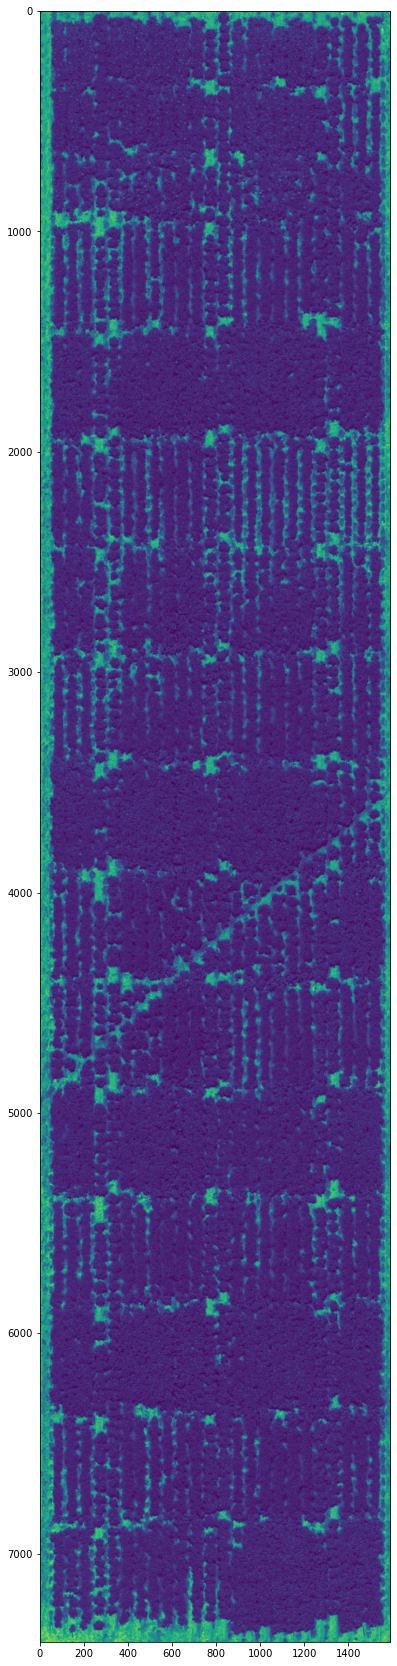

In [156]:
### load raw images, rotate them, and add to a np.array
field_image = np.stack([ndimage.rotate(load_img(channel_name), angle=182.4, reshape=True) for channel_name in rededge_mx_band_wl])

ground_truth = pd.read_csv(params["ground_truth_path"])

# origin is upper left
y_limits = [2400, 9800]
x_limits = [1460, 3050]

# crop to desired size (channels, y axis, x axis)
field_image = field_image[:, y_limits[0] : y_limits[1], x_limits[0] : x_limits[1]]
print(f"final field_image.shape: {field_image.shape}")
show_image(field_image[0])

# Congratulations! You have a field_image with all ten bands. 